### A notebook for some random experiments

#### Tuning rf model (1d)

In [28]:
from utility import gen_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from matplotlib import pyplot as plt

N = 1000
ntest = 100
setting = 1
sigma = 0.5 if setting in [1, 2, 3, 4] else 0.2
cov = 0.1
dim = 10

`dim` has minor effect on the performance of linear model, but the impact is huge for rf.

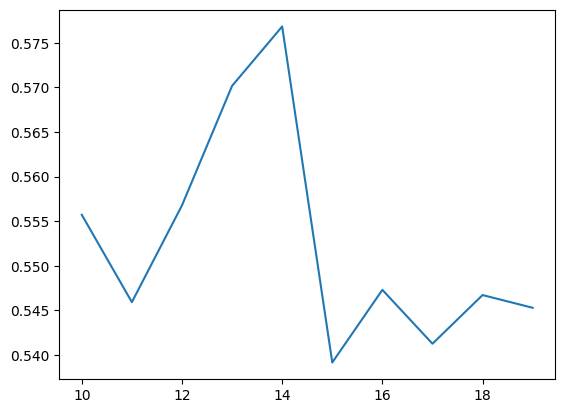

In [31]:
def get_rsq(dim):
    all_r = 0
    for t in range(10):
        Xtrain, Ytrain, _ = gen_data(setting, N, sigma, dim=dim)
        Xvalid, Yvalid, _ = gen_data(setting, N, sigma, dim=dim)
        Xtest, Ytest, _ = gen_data(setting, ntest, sigma, dim=dim)
        
        if setting == 1:
            transf = lambda x : np.column_stack((x, x[:, 0] * x[:, 1], x[:, 0] * x[:, 2], x[:, 1] * x[:, 2], x[:, 0] * x[:, 1] * x[:, 2]))
        if setting in [2, 3, 4]:
            transf = lambda x : np.column_stack((x, x[:, 0] * x[:, 1]))
        if setting == 5:
            transf = lambda x : np.column_stack((x, x[:, 0] * x[:, 1], x[:, 0] * x[:, 3], x[:, 1] * x[:, 3], x[:, 0] * x[:, 1] * x[:, 3]))
        if setting in [6, 7, 8]:
            transf = lambda x : np.column_stack((x, x[:, 0] * x[:, 1]))
        Xtrain = transf(Xtrain)
        Xvalid = transf(Xvalid)
        Xtest = transf(Xtest)

        lin = LinearRegression()
        lin.fit(Xtrain, 1 * (Ytrain > 0))
        Ypred = lin.predict(Xtest)
        all_r += r2_score(1 * (Ytest > 0), Ypred)
    return all_r / 10

res = []
xrange = np.arange(10, 20, 1)
for i in xrange:
    res.append(get_rsq(i))
plt.plot(xrange, res)
plt.show()

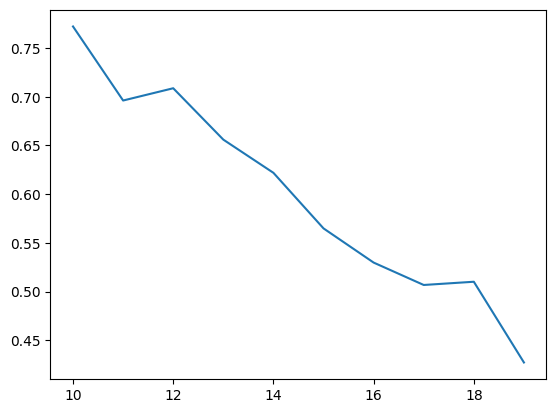

In [30]:
def get_rsq(dim):
    all_r = 0
    r = []
    for t in range(10):
        Xtrain, Ytrain, _ = gen_data(setting, N, sigma, dim=dim)
        Xvalid, Yvalid, _ = gen_data(setting, N, sigma, dim=dim)
        Xtest, Ytest, _ = gen_data(setting, ntest, sigma, dim=dim)

        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, random_state=0)

        rf.fit(Xtrain, 1 * (Ytrain > 0))

        Ypred = rf.predict(Xtest) 

        all_r += r2_score(1 * (Ytest > 0), Ypred)
        r.append(r2_score(1 * (Ytest > 0), Ypred))
    return all_r / 10

res = []
xrange = np.arange(10, 20, 1)
for i in xrange:
    res.append(get_rsq(i))
plt.plot(xrange, res)
plt.show()

In [134]:
setting = 2
dim = 10
all_r = 0

for t in range(10):
    Xtrain, Ytrain, _ = gen_data(setting, N, sigma, dim=dim)
    Xvalid, Yvalid, _ = gen_data(setting, N, sigma, dim=dim)
    Xtest, Ytest, _ = gen_data(setting, ntest, sigma, dim=dim)

    if setting == 1:
        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, random_state=0)
    if setting == 5:
        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, min_samples_leaf=20, min_samples_split=20, random_state=0)
    if setting == 2:
        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, random_state=0)
    if setting == 6:
        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, random_state=0)

    rf.fit(Xtrain, 1 * (Ytrain > 0))

    Ypred = rf.predict(Xtest) 

    all_r += r2_score(1 * (Ytest > 0), Ypred)
all_r / 10

0.5394483326776555

#### Tuning mlp model (1d)

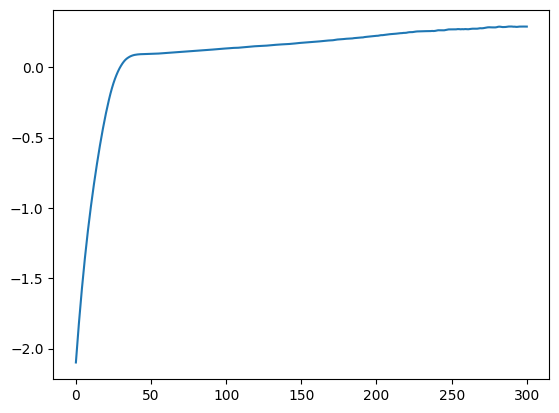

0.5207365291631905


In [175]:
from utility import gen_data
from sklearn.neural_network import MLPRegressor

setting = 2
dim = 10
sigma = 0.5 if setting in [1, 2, 3, 4] else 0.2
N = 1000
all_r = 0

for t in range(10):
    Xtrain, Ytrain, mu_train = gen_data(setting, N, sigma, dim=dim)
    Xvalid, Yvalid, mu_valid = gen_data(setting, N, sigma, dim=dim)
    Xtest, Ytest, _ = gen_data(setting, ntest, sigma, dim=dim)

    if setting == 1:
        mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=0.5, max_iter=1000, learning_rate_init=1e-4, early_stopping=True, tol=1e-6)
    if setting == 2:
        mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=0.5, max_iter=1000, learning_rate_init=1e-4, early_stopping=True, tol=1e-6)
    if setting == 5:
        mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=2, max_iter=1000, learning_rate_init=1e-4, early_stopping=True, tol=1e-6)
    if setting == 6:
        mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=0.2, max_iter=1000, learning_rate_init=1e-4, early_stopping=True, tol=1e-6)
    mlp.fit(Xtrain, 1 * (Ytrain > 0))

    if t == 9:
        plt.plot(mlp.validation_scores_)
        plt.show()

    Ypred = mlp.predict(Xtest)
    all_r += r2_score(1 * (Ytest > 0), Ypred)

print(all_r / 10)

#### Testing setting 9 - CQR

In [1]:
from utils import gen_data, BH, Bonferroni
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

N = 1000
setting = 9
Xtrain, Ytrain, mu_train = gen_data(setting, N, 0.5, dim=1)
Xvalid, Yvalid, mu_valid = gen_data(setting, N, 0.5, dim=1)

# scaling
# s = StandardScaler()
# Xtrain = s.fit_transform(Xtrain)
# s = StandardScaler()
# Xvalid = s.fit_transform(Xvalid)

# MAV = np.mean(np.absolute(Ytrain), axis=0)
# Ytrain /= MAV  
# MAV = np.mean(np.absolute(Yvalid), axis=0)
# Yvalid /= MAV  

rf = RandomForestRegressor(n_estimators=1000, max_features=1, min_samples_leaf=30)
rf.fit(Xtrain, Ytrain)
Ypred = rf.predict(Xvalid)
print(r2_score(Yvalid, Ypred))

0.4050670968864126


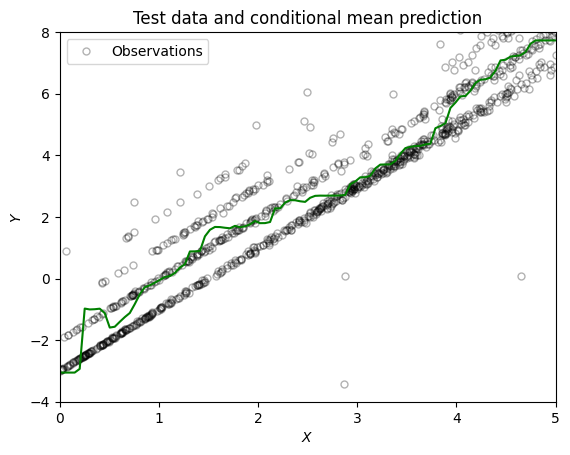

In [2]:
fig = plt.figure()
plt.plot(Xvalid, Yvalid, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')

Yplot_pred = []
for i in np.linspace(0, 5, 100):
    Yplot_pred.append(rf.predict([[i]]))
plt.plot(np.linspace(0, 5, 100), Yplot_pred, color='green')

plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data and conditional mean prediction')
plt.ylim((-4, 8))
plt.xlim((0, 5))
plt.show()

In [ ]:
from utils import BH
Xcalib, Ycalib, mu_calib = gen_data(setting, N, 0.5, dim=1)
Xtest, Ytest, _ = gen_data(setting, N, 0.5, dim=1)

calib_scores0 = - rf.predict(Xcalib)  
calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib) 

Ypred = rf.predict(Xtest) 
test_scores = -Ypred

BH_sub_sel, BH_sub_p = BH(calib_scores0, test_scores, 0.1)
BH_clip_sel, BH_clip, p = BH(calib_scores_2clip, test_scores, 0.1)



In [3]:
from quantile_forest import RandomForestQuantileRegressor

rf_q = RandomForestQuantileRegressor(n_estimators=1000, min_samples_leaf=40, max_features=1)
rf_q.fit(Xtrain, Ytrain)

RandomForestQuantileRegressor(max_features=1, min_samples_leaf=40,
                              n_estimators=1000)

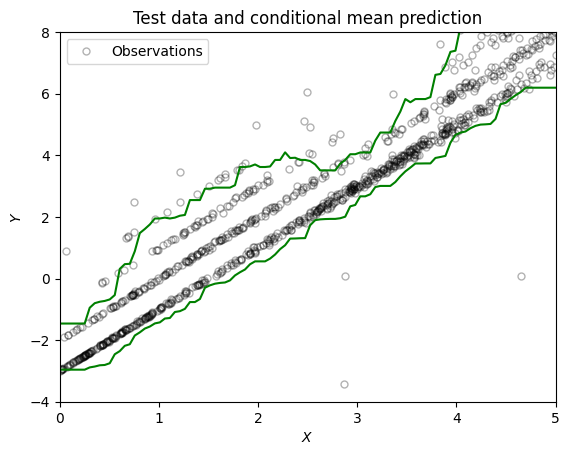

In [4]:
fig = plt.figure()
plt.plot(Xvalid, Yvalid, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')

Yplot_pred_lo = []
Yplot_pred_hi = []
for i in np.linspace(0, 5, 100):
    Yplot_pred_lo.append(rf_q.predict([[i]], quantiles=0.05))
    Yplot_pred_hi.append(rf_q.predict([[i]], quantiles=0.95))
plt.plot(np.linspace(0, 5, 100), Yplot_pred_lo, color='green')
plt.plot(np.linspace(0, 5, 100), Yplot_pred_hi, color='green')

plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data and conditional mean prediction')
plt.ylim((-4, 8))
plt.xlim((0, 5))
plt.show()

#### Testing 2d settings

In [5]:
from utility import gen_data_2d
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

N = 1000
ntest = 1000
setting = 2
sigma = 0.5 if setting in [1, 2] else 0.2
cov = 0.1

Xtrain, Ytrain, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=20)
Xvalid, Yvalid, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=20)
Xtest, Ytest, _, _, _ = gen_data_2d(setting, ntest, sigma, cov, dim=20)

In [119]:
rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, min_samples_leaf=1, min_samples_split=7, bootstrap=False)

rf.fit(Xtrain, Ytrain)
print(r2_score(Yvalid, rf.predict(Xvalid)))

0.7488959942764272


#### Tuning rf model (2d)

In [141]:
from utility import gen_data_2d
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from matplotlib import pyplot as plt

N = 1000
ntest = 100
setting = 2
sigma = 0.5 if setting in [1, 2] else 0.2
cov = 0.1
dim = 10

all_r = 0 

for t in range(10):
    Xtrain, Ytrain, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
    Xtest, Ytest, _, _, _ = gen_data_2d(setting, ntest, sigma, cov, dim=dim)
    if setting in [1, 2]:
        transf = lambda x : np.column_stack((x, x[:, 0] * x[:, 1], x[:, 1] * x[:, 2]))
    if setting == 5:
        transf = lambda x : np.column_stack((x, x[:, 0] * x[:, 1], x[:, 1] * x[:, 2], x[:, 0] * x[:, 2], x[:, 0] * x[:, 1] * x[:, 2],
                                                x[:, 0] * x[:, 1], x[:, 1] * x[:, 3], x[:, 0] * x[:, 3], x[:, 0] * x[:, 1] * x[:, 3]))
    if setting == 6:
        transf = lambda x : np.column_stack((x, x[:, 0] * x[:, 1], x[:, 1] * x[:, 3]))

    Xtrain = transf(Xtrain)
    Xtest = transf(Xtest)

    lin = LinearRegression()
    lin.fit(Xtrain, Ytrain)
    Ypred = lin.predict(Xtest) 

    all_r += r2_score(Ytest, Ypred)
all_r / 10

0.8691077197912616

In [121]:
N = 1000
ntest = 100
setting = 4
sigma = 0.5 if setting in [1, 2] else 0.2
cov = 0.1
dim = 10

all_r = 0

for t in range(10):
    Xtrain, Ytrain, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
    Xvalid, Yvalid, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
    Xtest, Ytest, _, _, _ = gen_data_2d(setting, ntest, sigma, cov, dim=dim)

    if setting == 1:
        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, min_samples_leaf=13, min_samples_split=13, random_state=0)
    if setting == 3:
        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, random_state=0)
    if setting == 2:
        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, random_state=0)
    if setting == 4:
        rf = RandomForestRegressor(n_estimators=50, max_depth=20, max_features=10, random_state=0)

    rf.fit(Xtrain, Ytrain)

    Ypred = rf.predict(Xtest) 

    all_r += r2_score(Ytest, Ypred)
all_r / 10

0.7206187665359595

#### Tuning mlp model (2d)

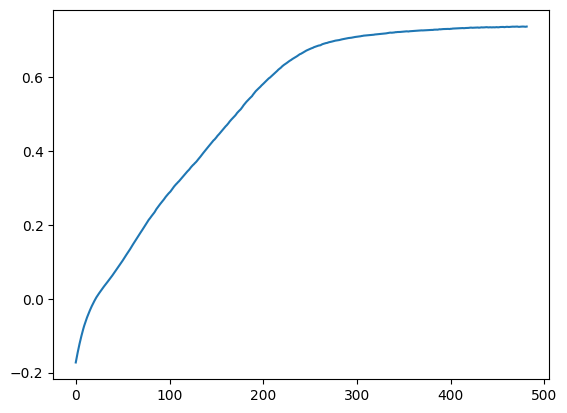

0.759108278615092


In [164]:
from utility import gen_data_2d
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from matplotlib import pyplot as plt

N = 1000
ntest = 100
setting = 4
sigma = 0.5 if setting in [1, 2] else 0.2
cov = 0.1
dim = 10

all_r = 0 

for t in range(10):
    Xtrain, Ytrain, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
    Xvalid, Yvalid, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
    Xtest, Ytest, _, _, _ = gen_data_2d(setting, ntest, sigma, cov, dim=dim)

    if setting == 1:
        mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=0.1, max_iter=1000, learning_rate_init=1e-4, early_stopping=True, tol=1e-6)
    if setting == 2:
        mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=0.1, max_iter=1000, learning_rate_init=1e-4, early_stopping=True, tol=1e-6)
    if setting == 3:
        mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=0.1, max_iter=1000, learning_rate_init=1e-4, early_stopping=True, tol=1e-6)
    if setting == 4:
        mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=0.1, max_iter=1000, learning_rate_init=1e-4, early_stopping=True, tol=1e-6)
    mlp.fit(Xtrain, Ytrain)

    if t == 9:
        plt.plot(mlp.validation_scores_)
        plt.show()

    Ypred = mlp.predict(Xtest)
    all_r += r2_score(Ytest, Ypred)

print(all_r / 10)

#### p-values and power of 1d settings

FDP: 0.8606060606060606 Power: 0.2795275590551181
Accuracy: 0.621


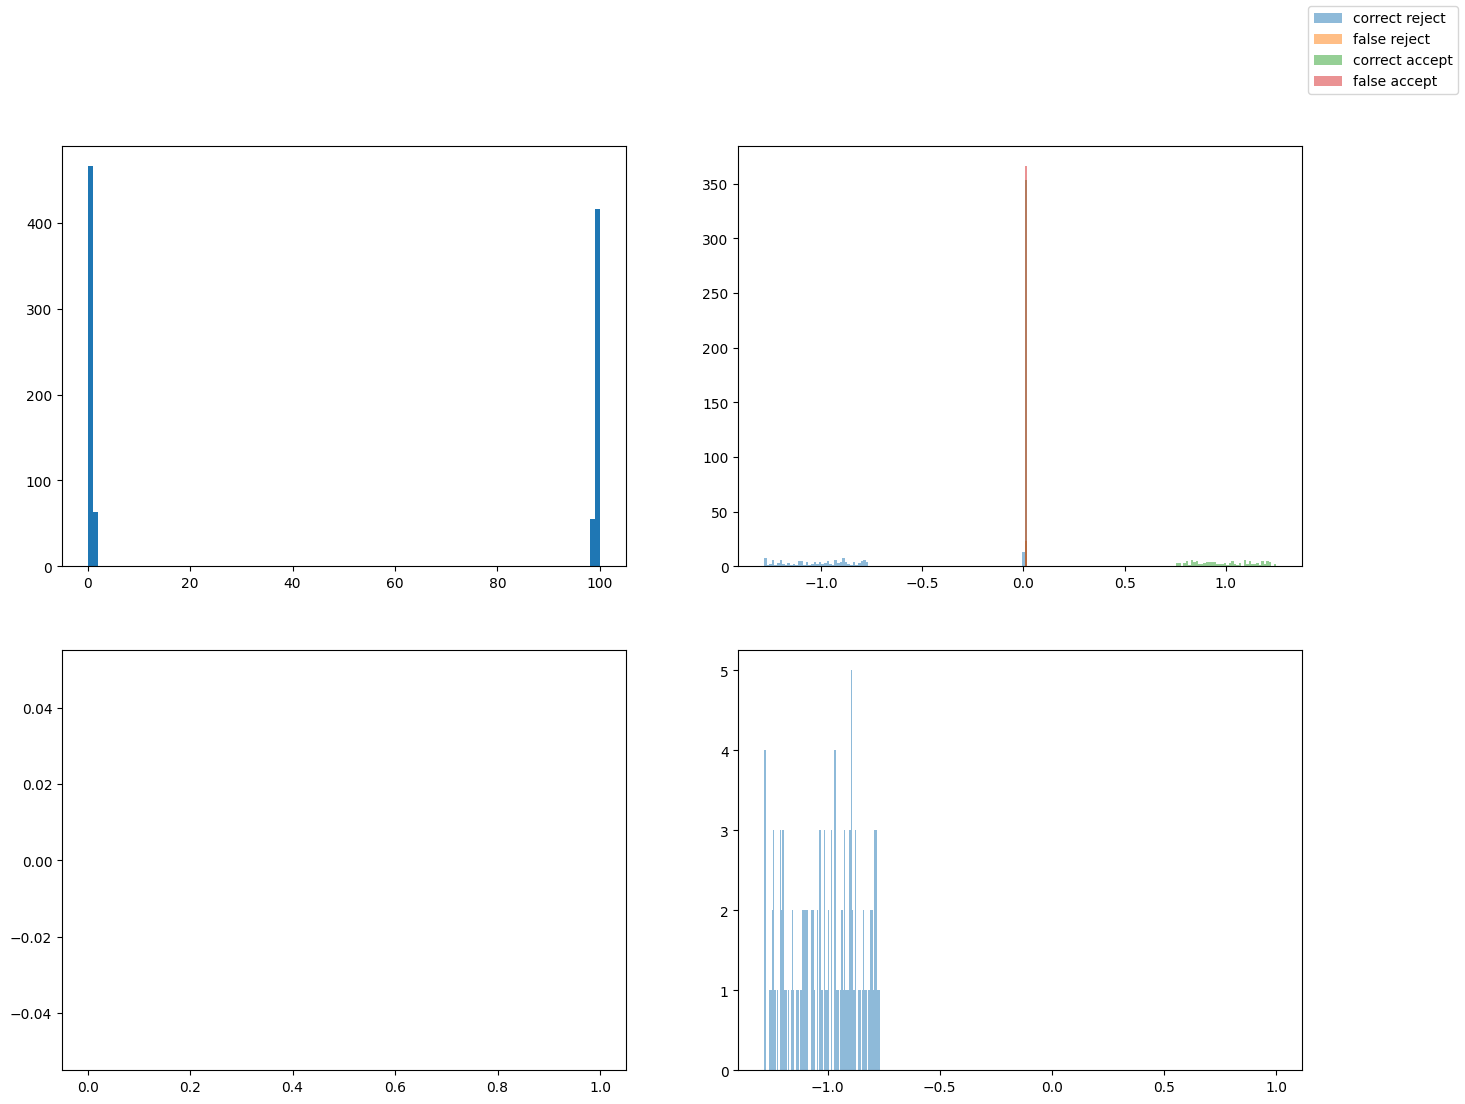

In [294]:
from utility import gen_data, BH
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from prediction_model import OracleRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

def intersect(l1, l2):
    return [value for value in l1 if value in l2]

N = 1000
ntest = 1000
setting = 5
sigma = 0.5 if setting in [1, 2, 3, 4] else 0.2
cov = 0
dim = 10


Xtrain, Ytrain, _ = gen_data(setting, N, sigma, dim=dim)
Xcalib, Ycalib, _ = gen_data(setting, N, sigma, dim=dim)
Xtest, Ytest, _ = gen_data(setting, ntest, sigma, dim=dim)

reject = np.where((Ytest > 0))[0]
notreject = np.where((Ytest <= 0))[0]

reg = OracleRegressor(setting)
reg.fit(Xtrain, Ytrain)
Ypred_calib = reg.predict(Xcalib)
Ypred = reg.predict(Xtest)

calib_scores = Ycalib - Ypred_calib                                            # BH_res
calib_scores0 = - Ypred_calib                                                  # BH_sub
calib_scores_2clip = 100 * ((Ycalib > 0)) - Ypred_calib

test_scores = - Ypred

BH_2clip = BH(calib_scores_2clip, test_scores, 0.1)
BH_2clip_c = [i for i in range(ntest) if i not in BH_2clip]

correct_reject = intersect(BH_2clip, reject)
false_reject = intersect(BH_2clip, notreject)
correct_accept = intersect(BH_2clip_c, notreject)
false_accept = intersect(BH_2clip_c, reject)

true_null = sum((Ytest > 0))
if len(BH_2clip) == 0:
    BH_2clip_fdp = 0
    BH_2clip_power = 0
else:
    BH_2clip_fdp = np.sum(Ytest[BH_2clip] > 0) / len(BH_2clip)
    BH_2clip_power = np.sum(Ytest[BH_2clip] > 0) / true_null if true_null != 0 else 0
print(f"FDP: {BH_2clip_fdp} Power: {BH_2clip_power}")
print(f"Accuracy: {accuracy_score(Ytest > 0, Ypred > 0)}")

# overall trend
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(16, 12))
axs[0][0].hist(calib_scores_2clip, bins=100)

axs[0][1].hist(test_scores[correct_reject], bins=100, alpha=0.5, label='correct reject')
axs[0][1].hist(test_scores[false_reject], bins=100, alpha=0.5, label='false reject')
axs[0][1].hist(test_scores[correct_accept], bins=100, alpha=0.5, label='correct accept')
axs[0][1].hist(test_scores[false_accept], bins=100, alpha=0.5, label='false accept')

# zoom in
axs[1][0].hist(calib_scores_2clip[np.where(calib_scores_2clip < 0)], bins=100)

axs[1][1].hist(test_scores[correct_reject][np.where(test_scores[correct_reject] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[false_reject][np.where(test_scores[false_reject] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[correct_accept][np.where(test_scores[correct_accept] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[false_accept][np.where(test_scores[false_accept] < 0)], bins=100, alpha=0.5)
fig.legend()
plt.show()

# for setting 6, directly predicting 0/1 target result in higher power. Will this apply to 2d case?

#### p-values and powers of 2d settings

r^2: 0.9168443223449005
FDP: 0.06854838709677419 Power: 0.8523985239852399
Accuracy: 0.932


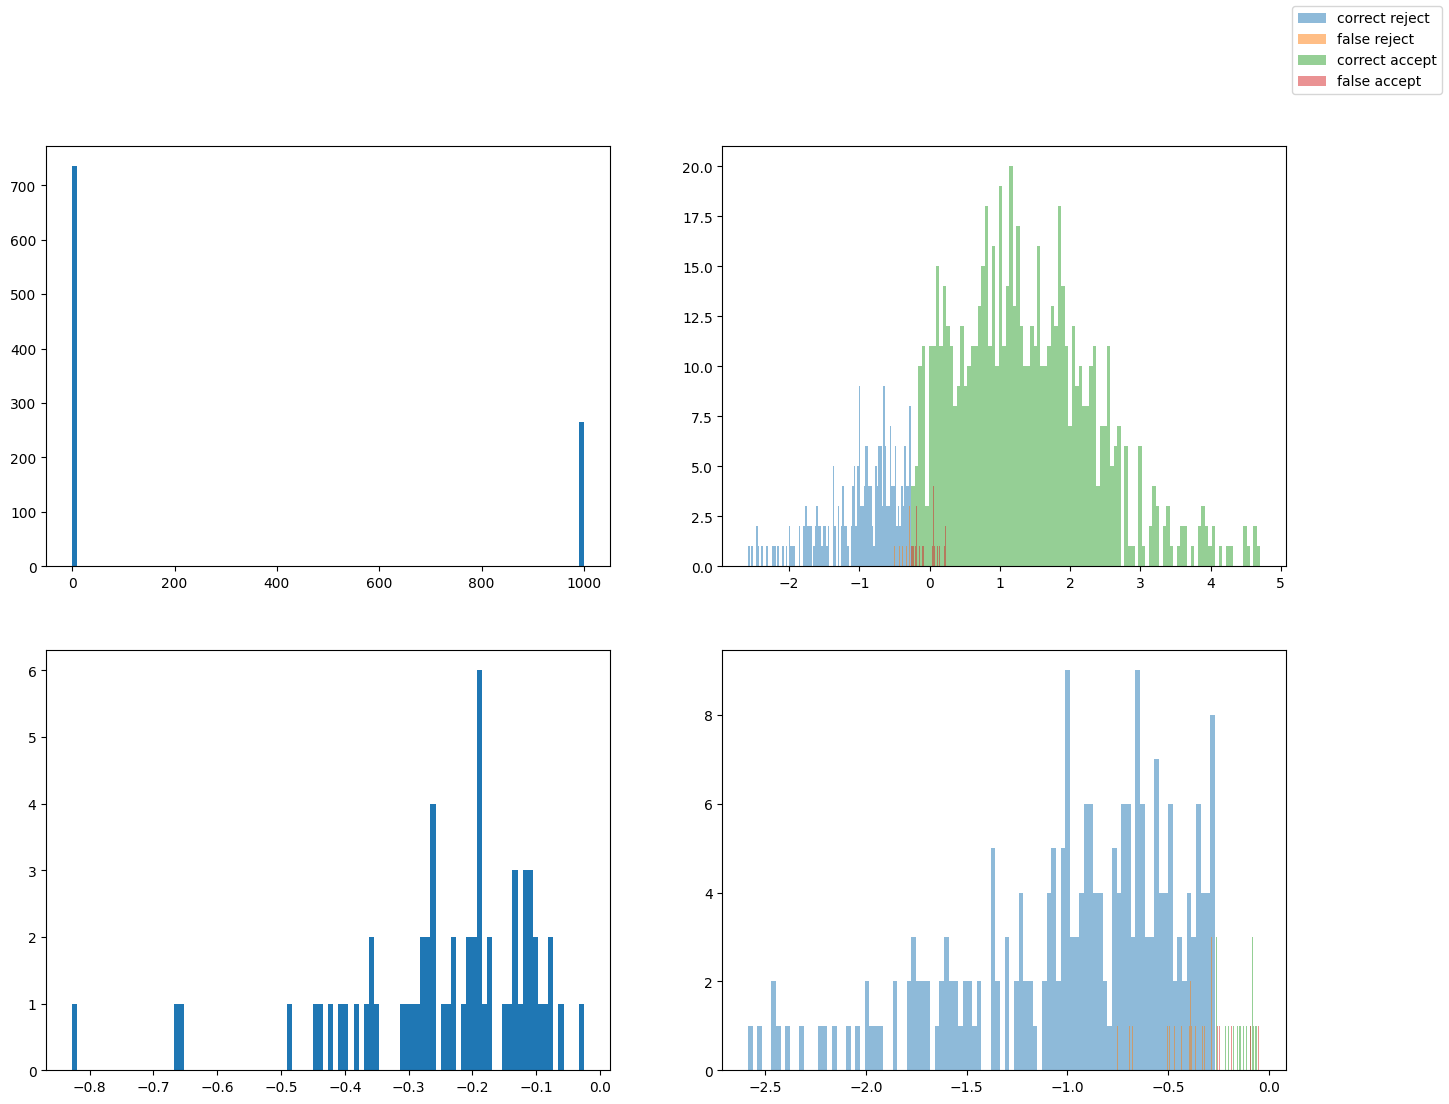

In [250]:
from utility import gen_data_2d, BH
from prediction_model import OracleRegressor2d, TrueRegressor2d
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

def dist(Y):
    l = []
    for i in range(len(Y)):
        if Y[i, 0] >= 0 and Y[i, 1] >= 0:
            l.append(max(Y[i, 0], Y[i, 1]))
        elif Y[i, 0] < 0 and Y[i, 1] < 0:
            l.append(-np.sqrt(Y[i, 0] ** 2 + Y[i, 1] ** 2))
        else:
            l.append(min(Y[i, 0], Y[i, 1]))
    return np.array(l)

def intersect(l1, l2):
    return [value for value in l1 if value in l2]

N = 1000
ntest = 1000
setting = 4
sigma = 0.1 if setting in [1, 2] else 0.1
cov = 0
dim = 10

Xtrain, Ytrain, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
Xcalib, Ycalib, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
Xtest, Ytest, _, _, _ = gen_data_2d(setting, ntest, sigma, cov, dim=dim)

reject = np.where((Ytest[:, 0] > 0) & (Ytest[:, 1] > 0))[0]
notreject = np.where((Ytest[:, 0] <= 0) | (Ytest[:, 1] <= 0))[0]

reg = OracleRegressor2d(setting)
reg.fit(Xtrain, Ytrain)
Ypred_calib = reg.predict(Xcalib)
Ypred = reg.predict(Xtest)

print(f"r^2: {r2_score(Ytest, Ypred)}")

calib_scores = dist(Ycalib) - dist(Ypred_calib)                                       # BH_res
calib_scores0 = - dist(Ypred_calib)                                                   # BH_sub
calib_scores_2clip = 1000 * ((Ycalib[:, 0] > 0) & (Ycalib[:, 1] > 0)) - dist(Ypred_calib)  

test_scores = - dist(Ypred)

BH_2clip = BH(calib_scores_2clip, test_scores, 0.1)
BH_2clip_c = [i for i in range(ntest) if i not in BH_2clip]

correct_reject = intersect(BH_2clip, reject)
false_reject = intersect(BH_2clip, notreject)
correct_accept = intersect(BH_2clip_c, notreject)
false_accept = intersect(BH_2clip_c, reject)

true_null = sum((Ytest[:, 0] > 0) & (Ytest[:, 1] > 0))
if len(BH_2clip) == 0:
    BH_2clip_fdp = 0
    BH_2clip_power = 0
else:
    BH_2clip_fdp = np.sum((Ytest[BH_2clip][:, 0] <= 0) | (Ytest[BH_2clip][:, 1] <= 0)) / len(BH_2clip)
    BH_2clip_power = np.sum((Ytest[BH_2clip][:, 0] > 0) & (Ytest[BH_2clip][:, 1] > 0)) / true_null if true_null != 0 else 0
print(f"FDP: {BH_2clip_fdp} Power: {BH_2clip_power}")
accuracy = accuracy_score((Ytest[:, 0] > 0) & (Ytest[:, 1] > 0), (Ypred[:, 0] > 0) & (Ypred[:, 1] > 0))
print(f"Accuracy: {accuracy}")

# overall trend
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(16, 12))
axs[0][0].hist(calib_scores_2clip, bins=100)

axs[0][1].hist(test_scores[correct_reject], bins=100, alpha=0.5, label='correct reject')
axs[0][1].hist(test_scores[false_reject], bins=100, alpha=0.5, label='false reject')
axs[0][1].hist(test_scores[correct_accept], bins=100, alpha=0.5, label='correct accept')
axs[0][1].hist(test_scores[false_accept], bins=100, alpha=0.5, label='false accept')

# zoom in
axs[1][0].hist(calib_scores_2clip[np.where(calib_scores_2clip < 0)], bins=100)

axs[1][1].hist(test_scores[correct_reject][np.where(test_scores[correct_reject] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[false_reject][np.where(test_scores[false_reject] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[correct_accept][np.where(test_scores[correct_accept] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[false_accept][np.where(test_scores[false_accept] < 0)], bins=100, alpha=0.5)
fig.legend()
plt.show()

r^2: 0.2702027524031591
FDP: 0.09433962264150944 Power: 0.4675324675324675
Accuracy: 0.365


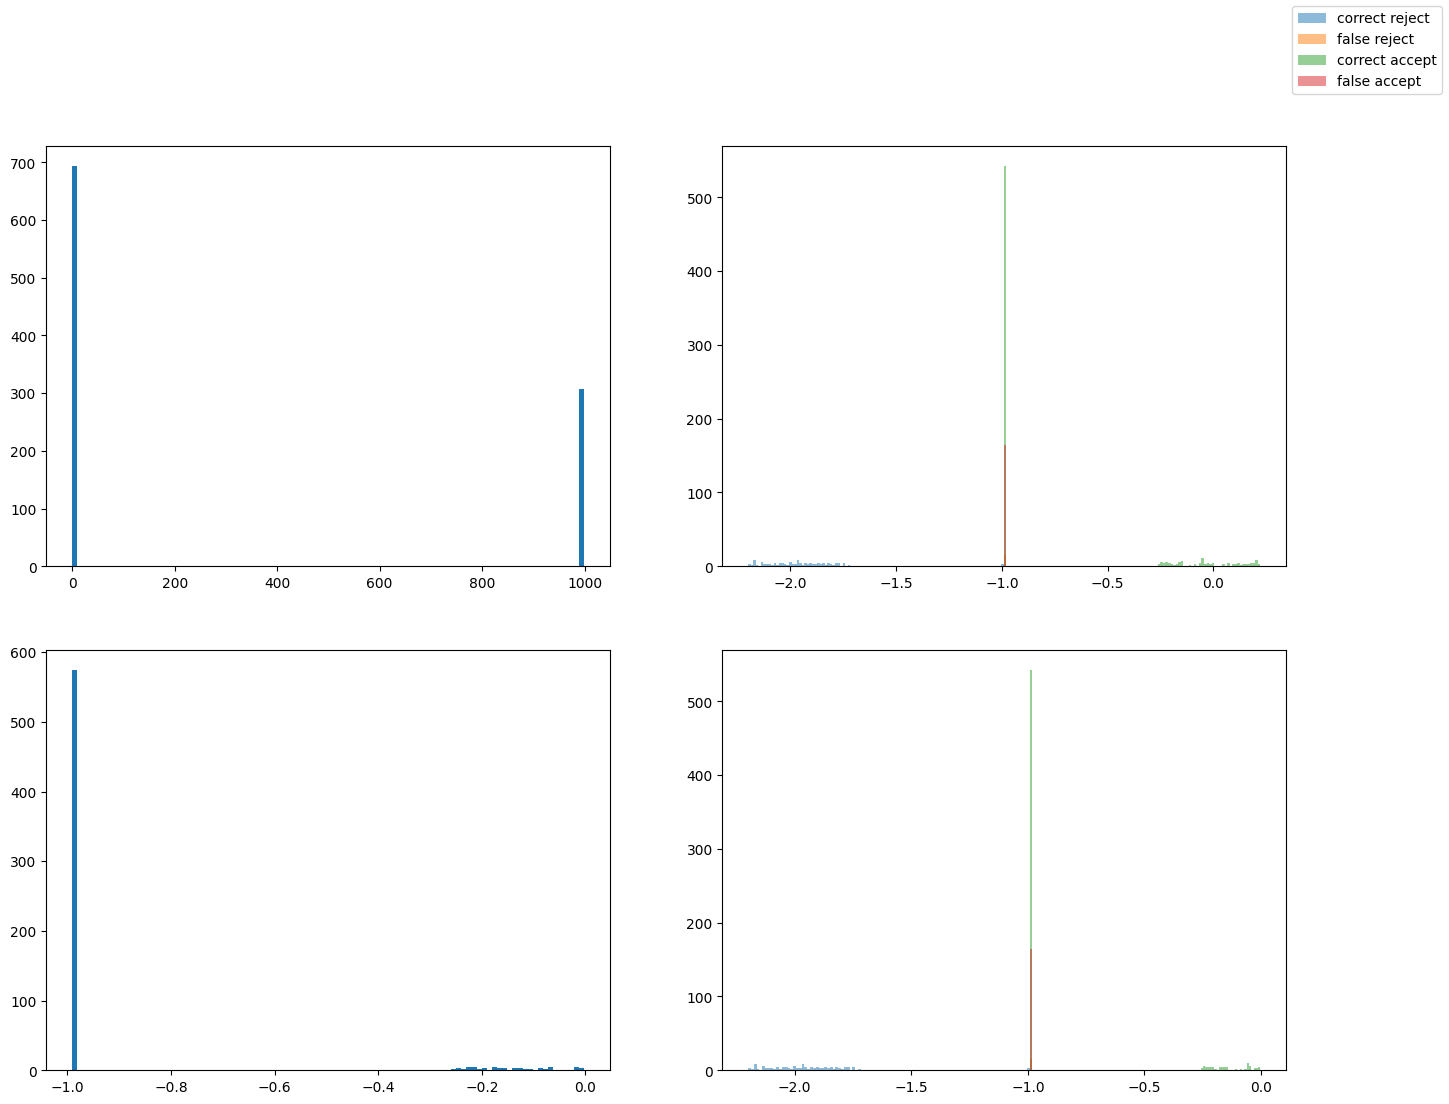

In [301]:
from utility import gen_data_2d, BH
from prediction_model import OracleRegressor2d, TrueRegressor2d
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

def dist(Y):
    # Y is 0/1 2d
    l = []
    for i in range(len(Y)):
        l.append(Y[i][0] + Y[i][1])
    return np.array(l)

def intersect(l1, l2):
    return [value for value in l1 if value in l2]

N = 1000
ntest = 1000
setting = 3
sigma = 0.1 if setting in [1, 2] else 0.1
cov = 0
dim = 10

Xtrain, Ytrain, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
Xcalib, Ycalib, _, _, _ = gen_data_2d(setting, N, sigma, cov, dim=dim)
Xtest, Ytest, _, _, _ = gen_data_2d(setting, ntest, sigma, cov, dim=dim)

reject = np.where((Ytest[:, 0] > 0) & (Ytest[:, 1] > 0))[0]
notreject = np.where((Ytest[:, 0] <= 0) | (Ytest[:, 1] <= 0))[0]

reg = OracleRegressor2d(setting)
reg.fit(Xtrain, np.column_stack((Ytrain[:, 0] > 0, Ytrain[:, 1] > 0)))
Ypred_calib = reg.predict(Xcalib)
Ypred = reg.predict(Xtest)

print(f"r^2: {r2_score(np.column_stack((Ytest[:, 0] > 0, Ytest[:, 1] > 0)), Ypred)}")

# HOW TO ADJUST CONFORMITY SCORE FOR 0/1 PREDICTION?

calib_scores = dist(Ycalib) - dist(Ypred_calib)                                       # BH_res
calib_scores0 = - dist(Ypred_calib)                                                   # BH_sub
calib_scores_2clip = 1000 * ((Ycalib[:, 0] > 0) & (Ycalib[:, 1] > 0)) - dist(Ypred_calib)  

test_scores = - dist(Ypred)

BH_2clip = BH(calib_scores_2clip, test_scores, 0.1)
BH_2clip_c = [i for i in range(ntest) if i not in BH_2clip]

correct_reject = intersect(BH_2clip, reject)
false_reject = intersect(BH_2clip, notreject)
correct_accept = intersect(BH_2clip_c, notreject)
false_accept = intersect(BH_2clip_c, reject)

true_null = sum((Ytest[:, 0] > 0) & (Ytest[:, 1] > 0))
if len(BH_2clip) == 0:
    BH_2clip_fdp = 0
    BH_2clip_power = 0
else:
    BH_2clip_fdp = np.sum((Ytest[BH_2clip][:, 0] <= 0) | (Ytest[BH_2clip][:, 1] <= 0)) / len(BH_2clip)
    BH_2clip_power = np.sum((Ytest[BH_2clip][:, 0] > 0) & (Ytest[BH_2clip][:, 1] > 0)) / true_null if true_null != 0 else 0
print(f"FDP: {BH_2clip_fdp} Power: {BH_2clip_power}")
accuracy = accuracy_score((Ytest[:, 0] > 0) & (Ytest[:, 1] > 0), (Ypred[:, 0] > 0) & (Ypred[:, 1] > 0))
print(f"Accuracy: {accuracy}")

# overall trend
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(16, 12))
axs[0][0].hist(calib_scores_2clip, bins=100)

axs[0][1].hist(test_scores[correct_reject], bins=100, alpha=0.5, label='correct reject')
axs[0][1].hist(test_scores[false_reject], bins=100, alpha=0.5, label='false reject')
axs[0][1].hist(test_scores[correct_accept], bins=100, alpha=0.5, label='correct accept')
axs[0][1].hist(test_scores[false_accept], bins=100, alpha=0.5, label='false accept')

# zoom in
axs[1][0].hist(calib_scores_2clip[np.where(calib_scores_2clip < 0)], bins=100)

axs[1][1].hist(test_scores[correct_reject][np.where(test_scores[correct_reject] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[false_reject][np.where(test_scores[false_reject] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[correct_accept][np.where(test_scores[correct_accept] < 0)], bins=100, alpha=0.5)
axs[1][1].hist(test_scores[false_accept][np.where(test_scores[false_accept] < 0)], bins=100, alpha=0.5)
fig.legend()
plt.show()

Some thoughts:
Prediction accuracy is extremely important. Consider the first histogram. There are two clusters: the left one are the wrongly-predicted ones and the right one are the correctly-predicted ones.
This is due to the design of the nonconformity score. If the prediction accuracy (in terms of whether in this rejection area or not) is poor, there will be more data in the left cluster. This will cause the relative rank of the nonconformity scores of test data to increase, thus worsening the rejection ability of the overall algorithm. 
The test noncomformity score histogram also consists of two clusters, and to ensure that the left cluster contains more data points that should be rejected, prediction accuracy is again important.

Question:
Why in the setting pair 1-5, 2-6, 3-7 and 4-8, the out-of-sample R^2 are similar but power/nsel is not? Does this imply that out-of-sample R^2 is a poor metric of prediction performance here?
Is this related to the fact that the prediction target is continuous but not zero-one?

TODO: use 2 zero-one predictors